# NLP Tweets Disaster Using Deep Learning

1. GitHub URL:https://github.com/XieXiao94/5511---NLP-Tweets-Disaster-Using-Deep-Learning/blob/main/NLP%20Tweets%20Disaster%20Using%20Deep%20Learning.ipynb


2. About this project:

    This project will study 7K tweets with their corresponding labels to build a model to predict whether the tweets are disaster or non-disaster. The type of learning is deep learning and the type of task is binary class classification.


3. Data Source:

    The dataset is from a kaggle project named 'Natural Language Processing with Disaster Tweets'.


4. Citation:

    Natural Language Processing with Disaster Tweets | Kaggle. (n.d.). https://www.kaggle.com/competitions/nlp-getting-started/overview


5. Dataset:

    The dataset includes both train and test datasets,  both in CSV format.  The training dataset has 7K tweets and 5 features. The 5 columns are ID, keyword, location, the text of the tweets and target (disaster or non-disaster). 
The test dataset contains 3k tweets and 4 features that are, ID, keyword, location, and text. ID and target are int64 types. The rest of the features are object types.


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import re
import emoji
# from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud
from collections import Counter

from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


from keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dropout
from keras.regularizers import l2
# from keras.layers import BatchNormalization
from keras.optimizers import Adam
from sklearn.metrics import f1_score



from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters


In [2]:
df_train = pd.read_csv('train.csv')

In [3]:
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
df_test = pd.read_csv('test.csv')
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


## EDA

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [7]:
df_train.isnull().sum()


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
df_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [9]:
df_train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

Text(0, 0.5, 'Count')

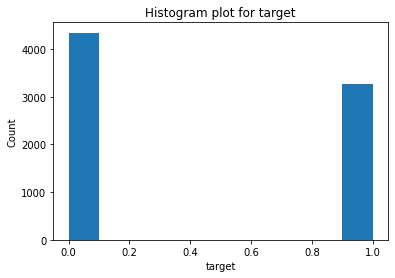

In [10]:
plt.hist(df_train['target'])
plt.title('Histogram plot for target')
plt.xlabel('target')
plt.ylabel('Count')

In [11]:
print('Compare between Disaster Tweets vs Non-disaster Tweets')
print('\nDisaster Tweets')
print(df_train.loc[df_train['target'] == 1, 'text'][:10])
print('\nNon-Disaster Tweets')
df_train.loc[df_train['target'] == 0, 'text'][:10]

Compare between Disaster Tweets vs Non-disaster Tweets

Disaster Tweets
0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object

Non-Disaster Tweets


15                  What's up man?
16                   I love fruits
17                Summer is lovely
18               My car is so fast
19    What a goooooooaaaaaal!!!!!!
20          this is ridiculous....
21               London is cool ;)
22                     Love skiing
23           What a wonderful day!
24                        LOOOOOOL
Name: text, dtype: object

In [12]:
print('Compare between Disaster Tweets and keywords vs Non-disaster Tweets and keywords')

print('\nDisaster tweets and keyword')
print(df_train.loc[df_train['target'] == 1, ['text', 'keyword']].iloc[80:86])
print('\nNon-Disaster tweets and keyword')
print(df_train.loc[df_train['target'] == 0, ['text', 'keyword']].iloc[80:86])

Compare between Disaster Tweets and keywords vs Non-disaster Tweets and keywords

Disaster tweets and keyword
                                                  text              keyword
169  The shooting or the airplane accident  https:/...  airplane%20accident
170  Could a drone cause an airplane accident? Pilo...  airplane%20accident
171  Early wake up call from my sister begging me t...            ambulance
172  http://t.co/AY6zzcUpnz Twelve feared killed in...            ambulance
173  Two air ambulances on scene of serious crash b...            ambulance
174  Twelve feared killed in Pakistani air ambulanc...            ambulance

Non-Disaster tweets and keyword
                                                  text              keyword
132  Aftershock back to school kick off was great. ...           aftershock
133  People who say it cannot be done should not in...           aftershock
134  'The first man gets the oyster the second man ...           aftershock
135  Anyone need a P/

#### Check if the texts contain URL, mention, hashtag and emoji


In [13]:
# create a function to check if texts has URL, mention, hashtag, or emoji
def check_url_mention_hashtag_emoji(text):
    url= re.compile(r"http\S+")
    mention = re.compile(r"@\w+")
    hashtag= re.compile(r"#")
    emoji = re.compile(
        "[" u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF" 
        "]+", flags=re.UNICODE)
    
    urls = bool(url.search(text))
    mentions = bool(mention.search(text))
    hashtags = bool(hashtag.search(text))
    emojis = bool(emoji.search(text))
    
    return urls, mentions, hashtags, emojis

df_url = df_train[df_train['text'].apply(lambda x: check_url_mention_hashtag_emoji(str(x))[0])]
df_mention = df_train[df_train['text'].apply(lambda x: check_url_mention_hashtag_emoji(str(x))[1])]
df_hashtag = df_train[df_train['text'].apply(lambda x: check_url_mention_hashtag_emoji(str(x))[2])]
df_emoji = df_train[df_train['text'].apply(lambda x: check_url_mention_hashtag_emoji(str(x))[3])]


print("\nNumber of Rows with URLs:", df_url.shape[0])
print(df_url[['text']].head())


print("\nNumber of Rows with Mentions:", df_mention.shape[0])
print(df_mention[['text']].head())


print("\nNumber of Rows with Hashtags:", df_hashtag.shape[0])
print(df_hashtag[['text']].head())


print("\nNumber of Rows with Emojis:", df_emoji.shape[0])
print(df_emoji[['text']].head())


Number of Rows with URLs: 3971
                                                 text
31  @bbcmtd Wholesale Markets ablaze http://t.co/l...
32  We always try to bring the heavy. #metal #RT h...
33  #AFRICANBAZE: Breaking news:Nigeria flag set a...
35  On plus side LOOK AT THE SKY LAST NIGHT IT WAS...
37  INEC Office in Abia Set Ablaze - http://t.co/3...

Number of Rows with Mentions: 2009
                                                 text
31  @bbcmtd Wholesale Markets ablaze http://t.co/l...
36  @PhDSquares #mufc they've built so much hype a...
43       SOOOO PUMPED FOR ABLAZE ???? @southridgelife
54  Noches El-Bestia '@Alexis_Sanchez: happy to se...
63  @Navista7 Steve these fires out here are somet...

Number of Rows with Hashtags: 1761
                                                text
0  Our Deeds are the Reason of this #earthquake M...
3  13,000 people receive #wildfires evacuation or...
4  Just got sent this photo from Ruby #Alaska as ...
5  #RockyFire Update => California H

## Data cleaning

Check the significant relationship between location vs target and keyword vs target.

In [14]:

chi2, p, dof, expected = chi2_contingency(pd.crosstab(df_train['location'], df_train['target']))

print('Chi-Square Test: Location VS Target: p-value = ', p)

chi2, p, dof, expected = chi2_contingency(pd.crosstab(df_train['keyword'], df_train['target']))

print('Chi-Square Test: keyword VS Target: p-value = ', p)

Chi-Square Test: Location VS Target: p-value =  0.01300195417927766
Chi-Square Test: keyword VS Target: p-value =  0.0


The p-value between location vs target and keyword vs target is all < 0.05. Which means there is a significant relationship between them. So I will fill the missing value with the word missing. The model can learn that from it.

In [15]:
df_train['keyword'].fillna('missing', inplace=True)
df_train['location'].fillna('missing', inplace=True)


Due to the limitation of our dataset, I added the keyword into the text to increase the dataset

In [16]:
df_train['text'] = df_train['keyword'] + ' ' + df_train['text']


## Pre-processing

1. lowercase all the text columns

2. Remove URLs, mentions and hashtags

3. Remove punctuation for the text Columns

4. Apply tokenize for the text Columns

5. Apply lemmatization for the Text Columns



Due to the limitation of this dataset, 

1. I did not remove stop words. The model can learn from the stop words and have more understanding of the  sentences overall.

2. I did not stem the texts. The model can learn from the present and past tense words and understand whether the disaster is happening or happened. 

3. I did not remove the repeated texts. The model can learn from the emotions expressed by the sender.


In [17]:

def preprocessing_df (df):
    df = df.str.lower()
    df = df.apply(lambda text: re.sub(r"http\S+", '', text))
    df = df.apply(lambda text: re.sub(r"@\w+", '', text))
    df = df.apply(lambda text: re.sub(r"#", '', text))

    df = df.replace(r'[^\w\s]', '', regex=True)
    
    df = df.apply(word_tokenize)
      
    df = df.apply(lambda tokens: [WordNetLemmatizer().lemmatize(word) for word in tokens])
    
    
    
    df = df.apply(' '.join)

    return df

In [18]:
df_train['text'] = preprocessing_df(df_train['text'])


In [19]:
print('Tweets after the pre-processing')

print('\nDisaster Tweets')
print(df_train.loc[df_train['target'] == 1, 'text'][:10])
print('\nNon-Disaster Tweets')
df_train.loc[df_train['target'] == 0, 'text'][:10]

Tweets after the pre-processing

Disaster Tweets
0    missing our deed are the reason of this earthq...
1        missing forest fire near la ronge sask canada
2    missing all resident asked to shelter in place...
3    missing 13000 people receive wildfire evacuati...
4    missing just got sent this photo from ruby ala...
5    missing rockyfire update california hwy 20 clo...
6    missing flood disaster heavy rain cause flash ...
7    missing im on top of the hill and i can see a ...
8    missing there an emergency evacuation happenin...
9    missing im afraid that the tornado is coming t...
Name: text, dtype: object

Non-Disaster Tweets


15              missing whats up man
16              missing i love fruit
17          missing summer is lovely
18         missing my car is so fast
19    missing what a goooooooaaaaaal
20        missing this is ridiculous
21            missing london is cool
22               missing love skiing
23      missing what a wonderful day
24                  missing looooool
Name: text, dtype: object

## More EDA
1. Word Cloud for disaster and non-disaster tweets
2. Top 10 most frequency words in disaster tweets and non-disaster tweets
3. Top 10 keywords in disaster_keywords and non-disaster_keywords

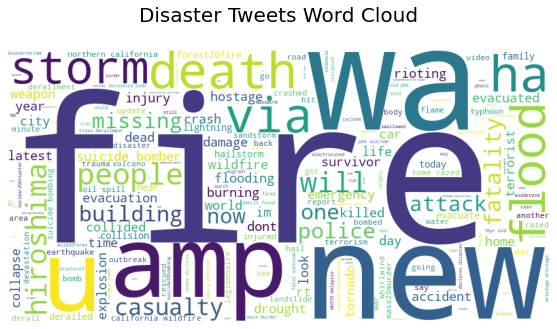

In [20]:
disaster = ' '.join(df_train[df_train['target'] == 1]['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(disaster)
plt.figure(figsize=(10, 5))
plt.title('Disaster Tweets Word Cloud\n',fontsize=20)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

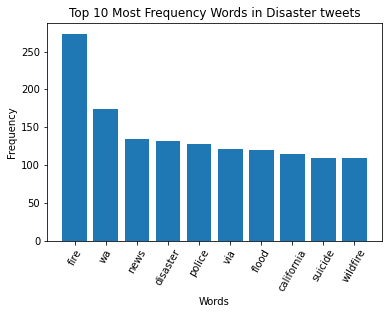

In [21]:
stop_words = set(stopwords.words('english'))
disaster_new = ' '.join(word for word in disaster.split() if word.lower() not in stop_words)


disaster_10 = Counter(disaster_new.split()).most_common(10)
disaster_10 = pd.DataFrame(disaster_10, columns=['Word', 'Frequency'])
plt.bar(disaster_10['Word'], disaster_10['Frequency'])
plt.title('Top 10 Most Frequency Words in Disaster tweets')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.show()

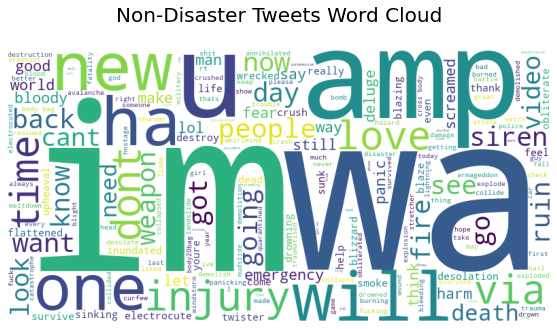

In [22]:
non_disaster = ' '.join(df_train[df_train['target'] == 0]['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_disaster)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.title('Non-Disaster Tweets Word Cloud\n',fontsize=20)
plt.axis('off')
plt.show()

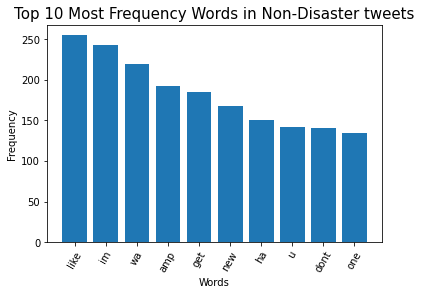

In [23]:
nondisaster_new = ' '.join(word for word in non_disaster.split() if word.lower() not in stop_words)


nondisaster_10 = Counter(nondisaster_new.split()).most_common(10)
nondisaster_10 = pd.DataFrame(nondisaster_10, columns=['Word', 'Frequency'])
plt.bar(nondisaster_10['Word'], nondisaster_10['Frequency'])
plt.title('Top 10 Most Frequency Words in Non-Disaster tweets',fontsize=15)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.show()

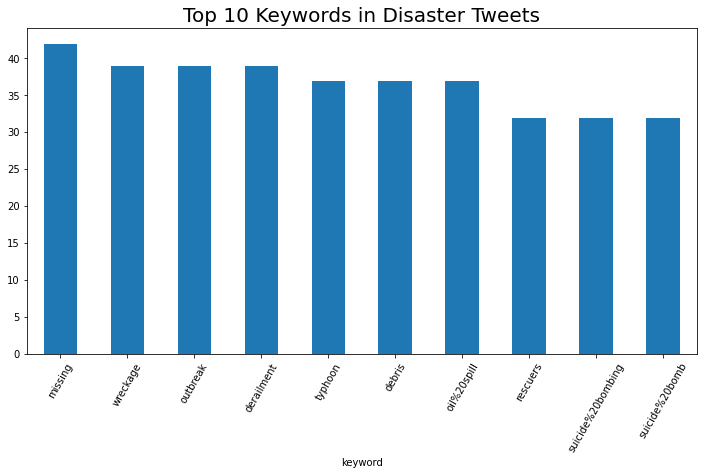

In [24]:
disaster_keyword = df_train[df_train['target'] == 1]['keyword'].value_counts()
disaster_keyword[:10].plot(kind='bar', figsize=(12, 6))
plt.title('Top 10 Keywords in Disaster Tweets',fontsize=20)
plt.xticks(rotation=60)

plt.show()


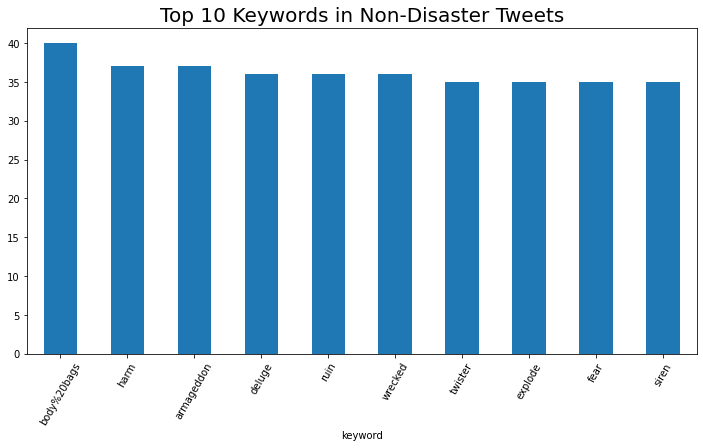

In [25]:
nondisaster_keyword = df_train[df_train['target'] == 0]['keyword'].value_counts()
nondisaster_keyword[:10].plot(kind='bar', figsize=(12, 6))
plt.title('Top 10 Keywords in Non-Disaster Tweets',fontsize=20)
plt.xticks(rotation=60)

plt.show()

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df_train['text'], df_train['target'], test_size=0.2, random_state=42)

### GloVe

GloVe uses matrix factorization to calculate word simultaneity
and is pre-trained on large text datasets.

Our dataset is small and limited, it will suffer from overfitting. To help with the issue. I will use GloVe word embeddings, especially the glove.6B.100d.txt. Because it contains a pre-trained model. It will increase our model performance and reduce the computation cost. Every word is encoded to a 100 dimensional vector, hence the filename is glove.6B.100d.txt.

1. reading the glove.6B.100d.txt
2. tokenize raw words
3. transfer raw words to integers
4. padded the integers to the same length
5. fill the embedding matrix with pre-trained vectors

In [27]:
embedding_dict = {}
embedding_dim = 100
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        word, *vector = line.split()
        embedding_dict[word] = np.array(vector, dtype='float32')

In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
unique_words = len(tokenizer.word_index) + 1


X_train = tokenizer.texts_to_sequences(X_train)
X_val= tokenizer.texts_to_sequences(X_val)

max_length = max(map(len, X_train))
X_train = pad_sequences(X_train, maxlen=max_length)
X_val = pad_sequences(X_val, maxlen=max_length)

y_train = y_train.values
y_val = y_val.values

embedding_matrix = np.zeros((unique_words, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Models:

For models, I plan to try different models starting from easy to complex models. Perform comparisons of their accuracy, loss and F1 score.

RNN: First, I will implement a simple RNN model. Most of the tweets are short texts. RNN is a basic model and works well for short sequences of data. 

LSTM: Secondly, I will implement an LSTM model. LSTM have gates that can help prevent vanishing gradient problems. Since I only did a few pre-processing of the train data. I believe the LSTM model can capture complex patterns from the dataset and achieve better accuracy. 

GRU: Lastly, I will implement the GRU model. GRU is a more balanced model between RNN and LSTM. It can help prevent the vanishing gradient problem with only two gates. It means the model can capture complex patterns and less computation costs. 

### RNN

In [29]:
rnn_model = Sequential([
    Embedding(input_dim=unique_words, output_dim=100, weights=[embedding_matrix], input_length=max_length, trainable=False),
    SimpleRNN(units=64, return_sequences=True),
    Dropout(0.5),
    SimpleRNN(units=64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


rnn_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           1649900   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32, 64)            10560     
                                                                 
 dropout (Dropout)           (None, 32, 64)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1668781 (6.37 MB)
Trainable params: 18881 

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('rnn_best_model.h5', monitor='val_loss', save_best_only=True)

rnn = rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
153/153 [==============================] - 4s 13ms/step - loss: 0.6773 - accuracy: 0.6371 - val_loss: 0.5435 - val_accuracy: 0.7529
Epoch 2/10
 11/153 [=>............................] - ETA: 1s - loss: 0.5825 - accuracy: 0.7273

/opt/anaconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


153/153 [==============================] - 2s 11ms/step - loss: 0.5331 - accuracy: 0.7599 - val_loss: 0.5151 - val_accuracy: 0.7594
Epoch 3/10
153/153 [==============================] - 2s 11ms/step - loss: 0.5034 - accuracy: 0.7742 - val_loss: 0.4939 - val_accuracy: 0.7816
Epoch 4/10
153/153 [==============================] - 2s 11ms/step - loss: 0.4796 - accuracy: 0.7929 - val_loss: 0.5004 - val_accuracy: 0.7865
Epoch 5/10
153/153 [==============================] - 2s 11ms/step - loss: 0.4584 - accuracy: 0.8007 - val_loss: 0.5232 - val_accuracy: 0.7479
Epoch 6/10
153/153 [==============================] - 2s 11ms/step - loss: 0.4602 - accuracy: 0.8021 - val_loss: 0.4811 - val_accuracy: 0.7874
Epoch 7/10
153/153 [==============================] - 2s 11ms/step - loss: 0.4323 - accuracy: 0.8165 - val_loss: 0.5030 - val_accuracy: 0.7931
Epoch 8/10
153/153 [==============================] - 2s 11ms/step - loss: 0.4284 - accuracy: 0.8132 - val_loss: 0.5331 - val_accuracy: 0.7775
Epoch 9/10

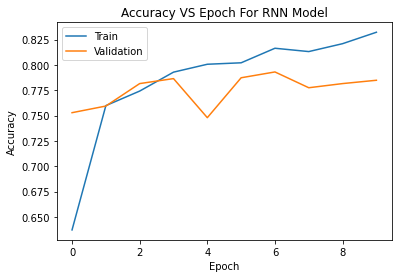

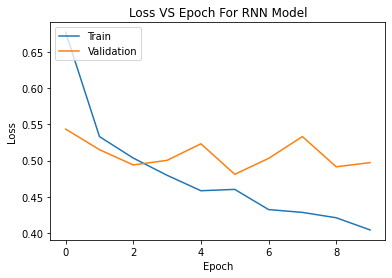

In [31]:
plt.plot(rnn.history['accuracy'])
plt.plot(rnn.history['val_accuracy'])
plt.title('Accuracy VS Epoch For RNN Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(rnn.history['loss'])
plt.plot(rnn.history['val_loss'])
plt.title('Loss VS Epoch For RNN Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [32]:
rnn_result = rnn_model.evaluate(X_val, y_val)

print('RNN Model Results on Validation Dataset')
print('Loss:', rnn_result[0])
print('Accuracy:', rnn_result[1])


48/48 [==============================] - 0s 4ms/step - loss: 0.4724 - accuracy: 0.7886
RNN Model Results on Validation Dataset
Loss: 0.47243815660476685
Accuracy: 0.7885751724243164


In [33]:
y_pred_rnn = (rnn_model.predict(X_val) >0.5).astype(int)

print("RNN Model's F1 Score on the Validation Dataset")
f1_score(y_val, y_pred_rnn)

48/48 [==============================] - 0s 4ms/step
RNN Model's F1 Score on the Validation Dataset


0.7200000000000001

### LSTM

In [34]:
lstm_model = Sequential([
    Embedding(input_dim=unique_words, output_dim=100,weights=[embedding_matrix], input_length=max_length, trainable=False),
    LSTM(units=64, return_sequences=True),
    Dropout(0.5),
    LSTM(units=64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


lstm_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 100)           1649900   
                                                                 
 lstm (LSTM)                 (None, 32, 64)            42240     
                                                                 
 dropout_2 (Dropout)         (None, 32, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1725229 (6.58 MB)
Trainable params: 7532

In [35]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('lstm_best_model.h5', monitor='val_loss', save_best_only=True)

lstm = lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
153/153 [==============================] - 8s 29ms/step - loss: 0.5213 - accuracy: 0.7498 - val_loss: 0.5138 - val_accuracy: 0.7611
Epoch 2/10
  6/153 [>.............................] - ETA: 3s - loss: 0.4561 - accuracy: 0.8125

/opt/anaconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


153/153 [==============================] - 4s 24ms/step - loss: 0.4492 - accuracy: 0.7995 - val_loss: 0.4766 - val_accuracy: 0.7783
Epoch 3/10
153/153 [==============================] - 4s 23ms/step - loss: 0.4287 - accuracy: 0.8163 - val_loss: 0.4970 - val_accuracy: 0.7775
Epoch 4/10
153/153 [==============================] - 4s 23ms/step - loss: 0.4222 - accuracy: 0.8163 - val_loss: 0.4676 - val_accuracy: 0.8038
Epoch 5/10
153/153 [==============================] - 4s 23ms/step - loss: 0.3984 - accuracy: 0.8272 - val_loss: 0.4869 - val_accuracy: 0.7882
Epoch 6/10
153/153 [==============================] - 4s 23ms/step - loss: 0.3821 - accuracy: 0.8415 - val_loss: 0.4871 - val_accuracy: 0.8087
Epoch 7/10
153/153 [==============================] - 4s 23ms/step - loss: 0.3644 - accuracy: 0.8483 - val_loss: 0.4840 - val_accuracy: 0.8013
Epoch 8/10
153/153 [==============================] - 4s 23ms/step - loss: 0.3508 - accuracy: 0.8590 - val_loss: 0.4722 - val_accuracy: 0.8013
Epoch 9/10

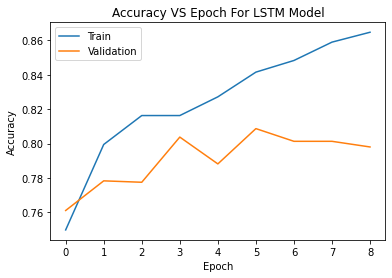

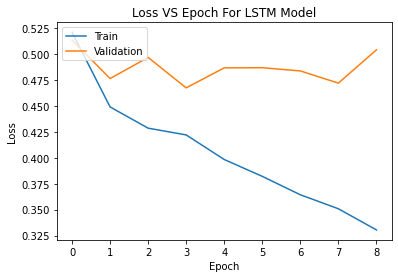

In [36]:
plt.plot(lstm.history['accuracy'])
plt.plot(lstm.history['val_accuracy'])
plt.title('Accuracy VS Epoch For LSTM Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(lstm.history['loss'])
plt.plot(lstm.history['val_loss'])
plt.title('Loss VS Epoch For LSTM Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [37]:
lstm_result = lstm_model.evaluate(X_val, y_val)

print('LSTM Model Results on Validation Dataset')
print('Loss:', lstm_result[0])
print('Accuracy:', lstm_result[1])

48/48 [==============================] - 0s 7ms/step - loss: 0.4358 - accuracy: 0.8129
LSTM Model Results on Validation Dataset
Loss: 0.4358425438404083
Accuracy: 0.8128693103790283


In [38]:
y_pred_lstm = (lstm_model.predict(X_val) >0.5).astype(int)

print("LSTM Model's F1 Score on the Validation Dataset")
f1_score(y_val, y_pred_lstm)

48/48 [==============================] - 1s 7ms/step
LSTM Model's F1 Score on the Validation Dataset


0.7553648068669527

### GRU Model

In [39]:
gru_model = Sequential([
    Embedding(input_dim=unique_words, output_dim=100, weights=[embedding_matrix], input_length=max_length,trainable=False),
    GRU(units=64, return_sequences=True),
    Dropout(0.5),
    GRU(units=64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


gru_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 32, 100)           1649900   
                                                                 
 gru (GRU)                   (None, 32, 64)            31872     
                                                                 
 dropout_4 (Dropout)         (None, 32, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1706797 (6.51 MB)
Trainable params: 5689

In [40]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('gru_best_model.h5', monitor='val_loss', save_best_only=True)

gru = gru_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
153/153 [==============================] - 8s 27ms/step - loss: 0.5332 - accuracy: 0.7389 - val_loss: 0.4913 - val_accuracy: 0.7824
Epoch 2/10
  4/153 [..............................] - ETA: 3s - loss: 0.4591 - accuracy: 0.7891

/opt/anaconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


153/153 [==============================] - 3s 23ms/step - loss: 0.4518 - accuracy: 0.7968 - val_loss: 0.4766 - val_accuracy: 0.7923
Epoch 3/10
153/153 [==============================] - 3s 22ms/step - loss: 0.4331 - accuracy: 0.8097 - val_loss: 0.5040 - val_accuracy: 0.7750
Epoch 4/10
153/153 [==============================] - 3s 23ms/step - loss: 0.4157 - accuracy: 0.8177 - val_loss: 0.4770 - val_accuracy: 0.7964
Epoch 5/10
153/153 [==============================] - 3s 23ms/step - loss: 0.3967 - accuracy: 0.8323 - val_loss: 0.4695 - val_accuracy: 0.7947
Epoch 6/10
153/153 [==============================] - 3s 22ms/step - loss: 0.3835 - accuracy: 0.8368 - val_loss: 0.4758 - val_accuracy: 0.7997
Epoch 7/10
153/153 [==============================] - 3s 22ms/step - loss: 0.3731 - accuracy: 0.8411 - val_loss: 0.4784 - val_accuracy: 0.7939
Epoch 8/10
153/153 [==============================] - 3s 23ms/step - loss: 0.3550 - accuracy: 0.8545 - val_loss: 0.4772 - val_accuracy: 0.8079
Epoch 9/10

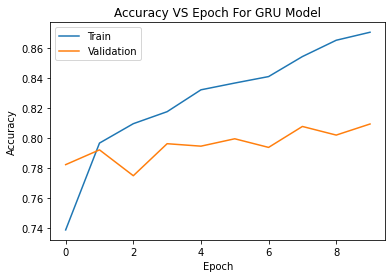

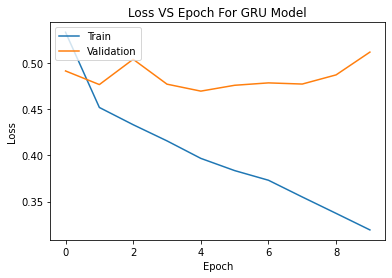

In [41]:
plt.plot(gru.history['accuracy'])
plt.plot(gru.history['val_accuracy'])
plt.title('Accuracy VS Epoch For GRU Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(gru.history['loss'])
plt.plot(gru.history['val_loss'])
plt.title('Loss VS Epoch For GRU Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [42]:
gru_result = gru_model.evaluate(X_val, y_val)

print('GRU Model Results on Validation Dataset')
print('Loss:', gru_result[0])
print('Accuracy:', gru_result[1])

48/48 [==============================] - 0s 6ms/step - loss: 0.4392 - accuracy: 0.7971
GRU Model Results on Validation Dataset
Loss: 0.4392319619655609
Accuracy: 0.7971109747886658


In [43]:
y_pred_gru = (gru_model.predict(X_val) >0.5).astype(int)

print("GRU Model's F1 Score on the Validation Dataset")

f1_score(y_val, y_pred_gru)

48/48 [==============================] - 1s 6ms/step
GRU Model's F1 Score on the Validation Dataset


0.7529976019184652

### Summary Table Without Hyperparameter Tuning

In [72]:
from tabulate import tabulate

rnn_table = [0.7886, 0.4724, 0.72]
lstm_table = [0.8129, 0.4358, 0.7554]
gru_table = [0.7971, 0.4392, 0.753]

data = [
    ['RNN'] + rnn_table,
    ['LSTM'] + lstm_table,
    ['GRU'] + gru_table
]

headers = ['Models','Validation data Accuracy', 'Validation data Loss', 'F1 Score']

table = tabulate(data, headers=headers, tablefmt='grid')

print(table)

+----------+----------------------------+------------------------+------------+
| Models   |   Validation data Accuracy |   Validation data Loss |   F1 Score |
+==========+============================+========================+============+
| RNN      |                     0.7886 |                 0.4724 |     0.72   |
+----------+----------------------------+------------------------+------------+
| LSTM     |                     0.8129 |                 0.4358 |     0.7554 |
+----------+----------------------------+------------------------+------------+
| GRU      |                     0.7971 |                 0.4392 |     0.753  |
+----------+----------------------------+------------------------+------------+


In [44]:
pip install keras-tuner


Note: you may need to restart the kernel to use updated packages.


### Hyperparameter Tuning
From the accuracy,loss and F1 score result. We can see that LSTM model has the highest accuracy, lowest loss and highest F1 score. So I choose the LSTM model for hyperparameter tuning.

In [45]:
def lstm_hyper(hp):
    model = Sequential()
    
    model.add(Embedding(input_dim=unique_words, 
                       output_dim=100, 
                       weights=[embedding_matrix], 
                       input_length=max_length,
                       trainable=False))
    
    units = hp.Int('lstm_units', min_value=64, max_value=225, step=32)
    model.add(LSTM(units=units, return_sequences=True))
    
        
    rate = hp.Float('dropout_rate1', min_value = 0.2, max_value=0.8, step = 0.1)
    model.add(Dropout(rate))
    
    units_2 = hp.Int('lstm_units_2', min_value=64, max_value=225, step=32)
    model.add(LSTM(units=units_2, return_sequences=False))
    
    model.add(Dropout(rate))

    model.add(Dense(1, activation='sigmoid'))
    
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(
    lstm_hyper,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir_lstm',
    project_name='lstm_tuning')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('lstm_hyper_best_model.h5', monitor='val_loss', save_best_only=True)

tuner.search(X_train, y_train, 
             epochs=10, 
             validation_split=0.2, 
             callbacks=[early_stopping, model_checkpoint])


Trial 10 Complete [00h 01m 32s]
val_loss: 0.4620251804590225

Best val_loss So Far: 0.4586329758167267
Total elapsed time: 00h 30m 29s


In [93]:
best_hypers = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best hyperparameters for LSTM model are:
{best_hypers.get('lstm_units')} units in the dense layer.
{best_hypers.get('lstm_units_2')} units in the dense layer.
{best_hypers.get('dropout_rate1')} dropout_rate.

{best_hypers.get('learning_rate')} learning rate for the optimizer.
""")


Best hyperparameters for LSTM model are:
224 units in the dense layer.
96 units in the dense layer.
0.4 dropout_rate.

0.001370856638680745 learning rate for the optimizer.



In [94]:
lstm_hyper_model = tuner.hypermodel.build(best_hypers)

lstm_hyper_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 32, 100)           1649900   
                                                                 
 lstm_2 (LSTM)               (None, 32, 224)           291200    
                                                                 
 dropout_6 (Dropout)         (None, 32, 224)           0         
                                                                 
 lstm_3 (LSTM)               (None, 96)                123264    
                                                                 
 dropout_7 (Dropout)         (None, 96)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 97        
                                                                 
Total params: 2064461 (7.88 MB)
Trainable params: 4145

In [47]:
lstm_best = lstm_hyper_model.fit(X_train, y_train, 
                    epochs=10, 
                    validation_split=0.2, 
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
153/153 [==============================] - 15s 68ms/step - loss: 0.4940 - accuracy: 0.7707 - val_loss: 0.5106 - val_accuracy: 0.7594
Epoch 2/10
153/153 [==============================] - 10s 64ms/step - loss: 0.4480 - accuracy: 0.7999 - val_loss: 0.4712 - val_accuracy: 0.7857
Epoch 3/10
153/153 [==============================] - 11s 70ms/step - loss: 0.4290 - accuracy: 0.8149 - val_loss: 0.4614 - val_accuracy: 0.7947
Epoch 4/10
153/153 [==============================] - 11s 71ms/step - loss: 0.4055 - accuracy: 0.8249 - val_loss: 0.4850 - val_accuracy: 0.7972
Epoch 5/10
153/153 [==============================] - 11s 72ms/step - loss: 0.3791 - accuracy: 0.8461 - val_loss: 0.5222 - val_accuracy: 0.8030
Epoch 6/10
153/153 [==============================] - 11s 73ms/step - loss: 0.3559 - accuracy: 0.8516 - val_loss: 0.4860 - val_accuracy: 0.7906
Epoch 7/10
153/153 [==============================] - 11s 69ms/step - loss: 0.3366 - accuracy: 0.8629 - val_loss: 0.4704 - val_accuracy:

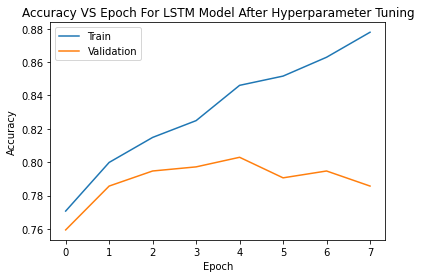

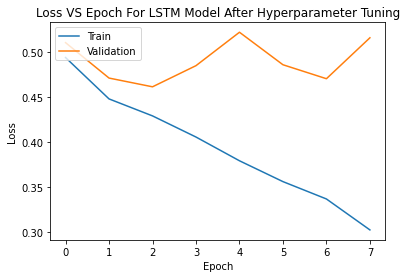

In [57]:
plt.plot(lstm_best.history['accuracy'])
plt.plot(lstm_best.history['val_accuracy'])
plt.title('Accuracy VS Epoch For LSTM Model After Hyperparameter Tuning')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(lstm_best.history['loss'])
plt.plot(lstm_best.history['val_loss'])
plt.title('Loss VS Epoch For LSTM Model After Hyperparameter Tuning')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [58]:
lstm_best_result = lstm_hyper_model.evaluate(X_val, y_val)

print('LSTM Model Results on Validation Dataset After Hyperparameter Tuning')
print('Loss:', lstm_best_result[0])
print('Accuracy:', lstm_best_result[1])

48/48 [==============================] - 2s 24ms/step - loss: 0.4416 - accuracy: 0.8122
LSTM Model Results on Validation Dataset After Hyperparameter Tuning
Loss: 0.44157037138938904
Accuracy: 0.8122127652168274


In [48]:
y_pred_best = (lstm_hyper_model.predict(X_val) >0.5).astype(int)

f1_score(y_val, y_pred_best)

48/48 [==============================] - 2s 22ms/step


0.7644151565074135

### Summary Table With Hyperparameter Tuning

In [70]:

from tabulate import tabulate

rnn_table = [0.7886, 0.4724, 0.72]
lstm_table = [0.8129, 0.4358, 0.7554]
gru_table = [0.7971, 0.4392, 0.753]
lstm_best_table = [0.8122,0.4416,0.7644]

data = [
    ['RNN'] + rnn_table,
    ['LSTM'] + lstm_table,
    ['GRU'] + gru_table,
    ['LSTM (After Hyperparameter Tuning)'] + lstm_best_table
]

headers = ['Models','Validation data Accuracy', 'Validation data Loss', 'F1 Score']

table = tabulate(data, headers=headers, tablefmt='grid')

print(table)

+------------------------------------+----------------------------+------------------------+------------+
| Models                             |   Validation data Accuracy |   Validation data Loss |   F1 Score |
+====================================+============================+========================+============+
| RNN                                |                     0.7886 |                 0.4724 |     0.72   |
+------------------------------------+----------------------------+------------------------+------------+
| LSTM                               |                     0.8129 |                 0.4358 |     0.7554 |
+------------------------------------+----------------------------+------------------------+------------+
| GRU                                |                     0.7971 |                 0.4392 |     0.753  |
+------------------------------------+----------------------------+------------------------+------------+
| LSTM (After Hyperparameter Tuning) |        

## 1. Hyperparameter Tuning Summary:

LSTM has the highest accuracy, lowest loss and best f1 score. So I chose the LSTM model for hyperparameter tuning.

Pre-defined hyperparameter tuning rangs:

dense units from 64 to 225.

dropout rate from 0.2 to 0.8.

Second dense units from 64 to 225.

learning rates from 1e-4 to 1e-2.

I used the Keras tuner with the random search for hyperparameter tuning because it randomly picks parameters which will help reduce overfitting, less computation cost and can explore more parameters.

The result show:

Best hyperparameters for LSTM model are:

224 units in the first dense layer.

96 units in the second dense layer.

0.4 dropout_rate.

0.001370856638680745 learning rate for the optimizer.

After retrain the model with the best parameters. The performance of the model has increased significantly. Please see the summary table.

## 2. Analysis:

From the summary table, we can see that the LSTM model has the best performance.

The LSTM model outperformed the RNN model.  The LSTM model is more complex than the RNN model and works well to prevent vanishing gradient problems, Which allows the LSTM model to capture more complex patterns. It helps achieve higher accuracy.

The LSTM model's result in loss and f1 score is similar to the GRU model's result. However, it has a higher accuracy than the GRU model.


From the accuracy and loss plots, we can see that the model is suffering from overfitting issues. For hyperparameters,  I have tried normalization and regularization, but it makes the result worse. So I deleted it from the hyperparameter tuning.
I have also tried different units, dropout rates and learning rates. The overfitting issues have not been solved because the size of our dataset is too small.



### Predict on the test data

In [104]:
X_test = df_test['text']


In [105]:

X_test = tokenizer.texts_to_sequences(X_test)

X_test = pad_sequences(X_test, maxlen=max_length)


In [106]:
predictions = (lstm_hyper_model.predict(X_test) >0.5).astype(int)


102/102 [==============================] - 2s 22ms/step


In [107]:
df_test['target'] = predictions

In [108]:
final_df = df_test[['id','target']]
final_df.to_csv('final.csv',index=False)

## Conclusion:

After performing hyperparameter tuning using the random search tuner, validation data accuracy decreased from 0.8129 to 0.8122. The loss increased from 0.4358 to 0.4416. Even though the accuracy and loss result worsened, the f1 score increased from 0.554 to 0.7644. which means the model is getting better at classifying the disaster and non-disaster tweets.

## Learning and Takeawayes:

Preprocessing for tweets, we need to check the URLs, mentions, hashtags and emojis. When we do too much preprocessing, the result will get worse. The stop words, the stem of the tweets and repeated words will help the model learn and understand more of the sentences overall and situations. This will help models achieve better results.

GloVe is great for small datasets because it contains pre-trained models. 

LSTM is a more complex model than RNN, it is great for help with vanishing gradient problems. GRU is the more balanced model between RNN and LSTM.

When datasets are really small, advanced techniques or models won't effectively resolve overfitting issues or significantly increase the model performance. 

## Improvements:

Due to the limitation of the dataset, I tried different hyperparameter tuning methods and models. But it did not resolve overfitting issues and it did not increase the model performance. If I get more data, I would like to run the LSTM and GRU models again and compare the results. I would also be interested in doing location analysis, If I have more location data. 

## Reference:

1. GeeksforGeeks. (2024, January 3). Pre-trained Word embedding using Glove in NLP models. GeeksforGeeks. https://www.geeksforgeeks.org/pre-trained-word-embedding-using-glove-in-nlp-models/


2. Shahules. (2019, December 31). Basic EDA,Cleaning and GloVe. Kaggle. https://www.kaggle.com/code/shahules/basic-eda-cleaning-and-glove


3. Tuckerarrants. (2020, September 5). Disaster tweets - EDA, GLOVE, RNNS, BERT. Kaggle. https://www.kaggle.com/code/tuckerarrants/disaster-tweets-eda-glove-rnns-bert